# Teaching machines to see better: Improving CNNs and making them confess

In this we will discuss various techniques to improve the CNN, such as, data augmentation, dropout. We will then train a model that is better suited for our data. Finally we will learn about transfer learning, and leverage it to download a pretrained model and train an offspring that's better than any model we've seen so far.


<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/manning_tf2_in_action/blob/master/Ch07-Improving-CNNs-and-Explaining/7.1.Image_Classification_Advance.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

## Importing necessary libraries <a class="anchor" id="import"></a>

In [1]:
import tensorflow as tf
#import tensorflow_hub as hub
import requests
print("TensorFlow version: {}".format(tf.__version__))
import zipfile
import requests
import os
import time
import pandas as pd
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Concatenate, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import numpy as np
from PIL import Image
import tensorflow.keras.backend as K
import pickle
from tensorflow.keras.models import load_model, Model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Couldn't set memory_growth")
        pass
    
    
def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

# Fixing the random seed
random_seed=4321
fix_random_seed(random_seed)

TensorFlow version: 2.9.0


2022-07-27 20:59:46.022063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 20:59:46.027457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 20:59:46.027786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Downloading data <a class="anchor" id="download-data"></a>

For this chapter, we're going to use the tiny-imagenet dataset (200 categories of objects). This is a simplified version of the bigger and harder imagenet dataset (1000 categories of objects).

In [2]:
import os
import requests
import zipfile

# Retrieve the data
if not os.path.exists(os.path.join('data','tiny-imagenet-200.zip')):
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    # Get the file from web
    r = requests.get(url)

    if not os.path.exists('data'):
        os.mkdir('data')
    
    # Write to a file
    with open(os.path.join('data','tiny-imagenet-200.zip'), 'wb') as f:
        f.write(r.content)
else:
    print("The zip file already exists.")
    
if not os.path.exists(os.path.join('data', 'tiny-imagenet-200')):
    with zipfile.ZipFile(os.path.join('data','tiny-imagenet-200.zip'), 'r') as zip_ref:
        zip_ref.extractall('data')
else:
    print("The extracted data already exists")

The zip file already exists.
The extracted data already exists


## Results from the EDA

* There are 200 classes of data
* Each image is 64x64 RGB
* Training data has 500 images per each class
* Testing has 50 images per each class
* We separate 50 images from each class in the training set to create the validation set

```
n02124075 	Egyptian cat
n04067472 	reel
n04540053 	volleyball
n04099969 	rocking chair, rocker
n07749582 	lemon
```

## Creating the data generators <a class="anchor" id="create-data-pipeline"></a>

In the dataset, we currently have a,

* Training set: `train` directory
* Testing set: `val` directory

But to properly train a model we need three datasets,

* Training set - Used to train the model
* Validation set - Used to continuously monitor model performance while training
* Testing set - Used to test the model, only after training finishes

Therefore, we will separate a 10% from training data and feed this data through as a separate generator

Additionally, we are going to create data generators that can augment data. Particularly we are going to use following augmentation techniques.

* Randomly rotate the image
* Randomly shift on width
* Randomly shift on height
* Random brightness adjustments
* Random shear adjustments
* Random zoom in/out
* Randomly flip horizontally
* Random gamma correction
* Randomly occlude a small patch

In [3]:
# Section 7.1

from functools import partial

def get_test_labels_df(test_labels_path):
    """ Reading the test data labels for all files in the test set as a data frame """
    test_df = pd.read_csv(test_labels_path, sep='\t', index_col=None, header=None)
    test_df = test_df.iloc[:,[0,1]].rename({0:"filename", 1:"class"}, axis=1)
    return test_df
        

def get_train_valid_test_data_generators(batch_size, target_size):
    """ Get the training/validation/testing data generators """
    
    # Code listing 7.1
    # Defining a data-augmenting image data generator and a standard image data generator
    image_gen_aug = ImageDataGenerator(
        samplewise_center=False, rotation_range=30, width_shift_range=0.2,
        height_shift_range=0.2, brightness_range=(0.5,1.5), shear_range=5, 
        zoom_range=0.2, horizontal_flip=True, fill_mode='reflect', validation_split=0.1
    )
    image_gen = ImageDataGenerator(samplewise_center=False)
    
    # Code listing 7.2
    # Define a training data generator
    partial_flow_func = partial(
        image_gen_aug.flow_from_directory, 
        directory=os.path.join('data','tiny-imagenet-200', 'train'), 
        target_size=target_size, classes=None,
        class_mode='categorical', batch_size=batch_size, 
        shuffle=True, seed=random_seed)
    
    # Get the training data subset
    train_gen = partial_flow_func(subset='training')
    # Get the validation data subset
    valid_gen = partial_flow_func(subset='validation')    

    # Defining the test data generator
    test_df = get_test_labels_df(os.path.join('data','tiny-imagenet-200',  'val', 'val_annotations.txt'))
    test_gen = image_gen.flow_from_dataframe(
        test_df, directory=os.path.join('data','tiny-imagenet-200',  'val', 'images'), target_size=target_size, classes=None,
        class_mode='categorical', batch_size=batch_size, shuffle=False
    )
    return train_gen, valid_gen, test_gen

# Code listing 7.3
def data_gen_augmented_inceptionnet_v1(gen, random_gamma=False, random_occlude=False):
    for x,y in gen: 
        
        if x.ndim != 4:
            raise ValueError("This function is designed for a batch of images with 4 dims [b, h, w, c]")
            
        if random_gamma:
            # Gamma correction
            # Doing this in the image process fn doesn't help improve performance
            rand_gamma = np.random.uniform(0.9, 1.08, (x.shape[0],1,1,1))
            x = x**rand_gamma
        
        if random_occlude:
            # Randomly occluding sections in the image
            occ_size = 10
            occ_h, occ_w = np.random.randint(0, x.shape[1]-occ_size), np.random.randint(0, x.shape[2]-occ_size)
            x[::2,occ_h:occ_h+occ_size,occ_w:occ_w+occ_size,:] = np.random.choice([0.,128.,255.])
        
        # Image centering
        x -= np.mean(x, axis=(1,2,3), keepdims=True)
        
        # Making sure we replicate the target (y) three times
        yield x,(y,y,y)
        
batch_size = 128
target_size = (56,56)
# Getting the train,valid, test data generators
train_gen, valid_gen, test_gen = get_train_valid_test_data_generators(batch_size, target_size)
# Modifying the data generators to fit the model targets
# We augment data in the training set
train_gen_aux = data_gen_augmented_inceptionnet_v1(train_gen, random_gamma=True, random_occlude=True)
# We do not augment data in the validation/test datasets
valid_gen_aux = data_gen_augmented_inceptionnet_v1(valid_gen)
test_gen_aux = data_gen_augmented_inceptionnet_v1(test_gen)

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


## Validating the consistency of validation data

It always pays of to make sure the datasets you have behave in the way you intend them to behave. For example,

* Data augmentation should happen for training data
* Data augmentation should **not** happen for validation/testing data

In [4]:
from itertools import tee
all_labels = []
n_trials = 10

valid_gen_test = tee(valid_gen, n_trials)

for i in range(n_trials):    
    labels = []
    for j in range(5):
        _, ohe = next(valid_gen_test[i])
        # Convert one hot encoded to class labels
        labels.append(np.argmax(ohe, axis=-1))
        
    # Concat all labels
    labels = np.reshape(np.concatenate(labels, axis=0), (1,-1))        
    all_labels.append(labels)

# Concat all labels accross all trials
all_labels = np.concatenate(all_labels, axis=0)

# Assert the labels are equal across all trials
assert np.all(np.all(all_labels == all_labels[0,:], axis=0)), "Labels across multiple trials were not equal"
print("Successful! Labels across all trials were consistent.")

Successful! Labels across all trials were consistent.


## Plotting the augmented images

Here we will plot some of the training images (augmented) as well as validation images (not augmented). This also acts as a verification step to make sure we have desired augmentations applied to correct datasets.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

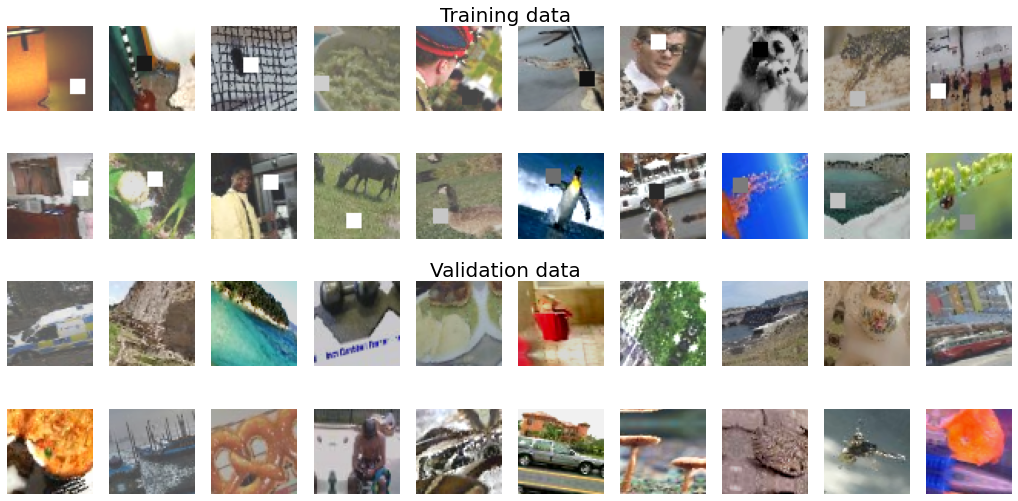

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

data = [] # Holds both training and validation samples to be plotted

# Getting training samples (20 samples)
for i, (x,y) in enumerate(train_gen_aux):
    if i>=20: break
    data.append((x[0,:,:,:]+128).astype('int32'))
    
# Getting validation samples (20 samples)
for i,(x,y) in enumerate(valid_gen_aux):
    if i>=20: break
    data.append((x[0,:,:,:]+128).astype('int32'))
    
# Creating a plot with 40 subplots (4 rows and 10 columns)
n_rows = 4
n_cols = 10
f, axes = plt.subplots(n_rows, n_cols, figsize=(18,9))

# Plot the training and validation images
# First 2 rows are training data
# Second 2 rows are validation data
for ri in range(n_rows):
    for ci in range(n_cols):
        # Plotting the correct image at ri,ci position in the plot
        i = ri*n_cols + ci
        axes[ri][ci].imshow(data[i])
        axes[ri][ci].axis('off')
        
        # Setting plot titles
        if ri==0 and ci == n_cols//2:
            axes[ri][ci].set_title("Training data", fontsize=20, pad=1, x=-0.15)
        elif ri==2 and ci == n_cols/2:
            axes[ri][ci].set_title("Validation data", fontsize=20, pad=1, x=-0.15)

## Defining the Inception net v1

Here we will be creating the Inception net v1 model using Keras Functional API. Compared to the one implemented in Chapter 6, this model will have dropout layers, Just before the final output layer and th auxiliary output layers.

In [6]:
# Section 7.1

from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Concatenate, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K

def inception(inp, n_filters):

    # 1x1 layer
    # init argument defaults to glorot_uniform
    out1 = Conv2D(n_filters[0][0], (1,1), strides=(1,1), activation='relu', padding='same')(inp)

    # 1x1 followed by 3x3
    out2_1 = Conv2D(n_filters[1][0], (1,1), strides=(1,1), activation='relu', padding='same')(inp)
    out2_2 = Conv2D(n_filters[1][1], (3,3), strides=(1,1), activation='relu', padding='same')(out2_1)

    # 1x1 followed by 5x5
    out3_1 = Conv2D(n_filters[2][0], (1,1), strides=(1,1), activation='relu', padding='same')(inp)
    out3_2 = Conv2D(n_filters[2][1], (5,5), strides=(1,1), activation='relu', padding='same')(out3_1)

    # 3x3 (pool) followed by 1x1
    out4_1 = MaxPool2D((3,3), strides=(1,1), padding='same')(inp)
    out4_2 = Conv2D(n_filters[3][0], (1,1), strides=(1,1), activation='relu', padding='same')(out4_1)

    out = Concatenate(axis=-1)([out1, out2_2, out3_2, out4_2])
    return out

# Code listing 7.4
def aux_out(inp,name=None):    
    avgpool1 = AvgPool2D((5,5), strides=(3,3), padding='valid')(inp)
    conv1 = Conv2D(128, (1,1), activation='relu', padding='same')(avgpool1)
    flat = Flatten()(conv1)
    dense1 = Dense(1024, activation='relu')(flat) 
    dense1 = Dropout(0.7)(dense1)
    aux_out = Dense(200, activation='softmax', name=name)(dense1)
    return aux_out

def stem(inp):
    conv1 = Conv2D(64, (7,7), strides=(1,1), activation='relu', padding='same')(inp)
    maxpool2 = MaxPool2D((3,3), strides=(2,2), padding='same')(conv1)
    lrn3 = Lambda(lambda x: tf.nn.local_response_normalization(x))(maxpool2)

    conv4 = Conv2D(64, (1,1), strides=(1,1), padding='same')(lrn3)
    conv5 = Conv2D(192, (3,3), strides=(1,1), activation='relu', padding='same')(conv4)
    lrn6 = Lambda(lambda x: tf.nn.local_response_normalization(x))(conv5)

    maxpool7 = MaxPool2D((3,3), strides=(1,1), padding='same')(lrn6)

    return maxpool7


def inception_v1():
    
    K.clear_session()
    
    inp = Input(shape=(56,56,3))
    stem_out = stem(inp)
    inc_3a = inception(stem_out, [(64,),(96,128),(16,32),(32,)])
    inc_3b = inception(inc_3a, [(128,),(128,192),(32,96),(64,)])

    maxpool = MaxPool2D((3,3), strides=(2,2), padding='same')(inc_3b)

    inc_4a = inception(maxpool, [(192,),(96,208),(16,48),(64,)])
    inc_4b = inception(inc_4a, [(160,),(112,224),(24,64),(64,)])

    aux_out1 = aux_out(inc_4a, name='aux1')

    inc_4c = inception(inc_4b, [(128,),(128,256),(24,64),(64,)])
    inc_4d = inception(inc_4c, [(112,),(144,288),(32,64),(64,)])
    inc_4e = inception(inc_4d, [(256,),(160,320),(32,128),(128,)])
    
    maxpool = MaxPool2D((3,3), strides=(2,2), padding='same')(inc_4e)
    
    aux_out2 = aux_out(inc_4d, name='aux2')

    inc_5a = inception(maxpool, [(256,),(160,320),(32,128),(128,)])
    inc_5b = inception(inc_5a, [(384,),(192,384),(48,128),(128,)])
    avgpool1 = AvgPool2D((7,7), strides=(1,1), padding='valid')(inc_5b)

    flat_out = Flatten()(avgpool1)
    flat_out = Dropout(0.4)(flat_out)
    out_main = Dense(200, activation='softmax', name='final')(flat_out)

    model = Model(inputs=inp, outputs=[out_main, aux_out1, aux_out2])
    model.compile(loss='categorical_crossentropy', 
                       optimizer='adam', metrics=['accuracy'])
    return model

model = inception_v1()
model.summary()

2022-07-27 20:59:58.173509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-27 20:59:58.173906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 20:59:58.174265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 20:59:58.174561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 56, 56, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 56, 56, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 28, 28, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 lambda (Lambda)                (None, 28, 28, 64)   0           ['max_pooling2d[0][0]']          
                                                                                              

                                                                                                  
 conv2d_21 (Conv2D)             (None, 14, 14, 160)  82080       ['concatenate_2[0][0]']          
                                                                                                  
 conv2d_23 (Conv2D)             (None, 14, 14, 224)  226016      ['conv2d_22[0][0]']              
                                                                                                  
 conv2d_25 (Conv2D)             (None, 14, 14, 64)   38464       ['conv2d_24[0][0]']              
                                                                                                  
 conv2d_26 (Conv2D)             (None, 14, 14, 64)   32832       ['max_pooling2d_6[0][0]']        
                                                                                                  
 concatenate_3 (Concatenate)    (None, 14, 14, 512)  0           ['conv2d_21[0][0]',              
          

 conv2d_49 (Conv2D)             (None, 7, 7, 320)    461120      ['conv2d_48[0][0]']              
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 128)    102528      ['conv2d_50[0][0]']              
                                                                                                  
 conv2d_52 (Conv2D)             (None, 7, 7, 128)    106624      ['max_pooling2d_11[0][0]']       
                                                                                                  
 concatenate_7 (Concatenate)    (None, 7, 7, 832)    0           ['conv2d_47[0][0]',              
                                                                  'conv2d_49[0][0]',              
                                                                  'conv2d_51[0][0]',              
                                                                  'conv2d_52[0][0]']              
          

## Training the model

Here we will train the model on augmented data with early stopping.

In [7]:
# Section 7.1

def get_steps_per_epoch(n_data, batch_size):
    """ Given the data size and batch size, gives the number of steps to travers the full dataset """
    if n_data%batch_size==0:
        return int(n_data/batch_size)
    else:
        return int(n_data*1.0/batch_size)+1

In [8]:
# Section 7.1

# Create a directory called eval which stores model performance
if not os.path.exists('eval'):
    os.mkdir('eval')
    
# Early stopping callback
es_callback = EarlyStopping(monitor='val_loss', patience=5)
# Logging the performance metrics to a CSV file
csv_logger = CSVLogger(os.path.join('eval','2_eval_data_aug_early_stopping.log'))

t1 = time.time()
history = model.fit(
    train_gen_aux, validation_data=valid_gen_aux, 
    steps_per_epoch=get_steps_per_epoch(int(0.9*(500*200)), batch_size), 
    validation_steps=get_steps_per_epoch(int(0.1*(500*200)),batch_size),
    epochs=50, callbacks=[es_callback, csv_logger]
)
t2 = time.time()

print("It took {} seconds to complete the training".format(t2-t1))

Epoch 1/50


2022-07-27 21:00:02.398791: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-07-27 21:00:03.914272: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.194, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


704/704 [==============================] - 201s 274ms/step - loss: 15.3934 - final_loss: 5.1318 - aux1_loss: 5.1228 - aux2_loss: 5.1388 - final_accuracy: 0.0139 - aux1_accuracy: 0.0148 - aux2_accuracy: 0.0135 - val_loss: 14.8895 - val_final_loss: 4.9756 - val_aux1_loss: 4.9440 - val_aux2_loss: 4.9699 - val_final_accuracy: 0.0240 - val_aux1_accuracy: 0.0256 - val_aux2_accuracy: 0.0264
Epoch 2/50
704/704 [==============================] - 188s 267ms/step - loss: 14.5781 - final_loss: 4.8388 - aux1_loss: 4.8528 - aux2_loss: 4.8865 - final_accuracy: 0.0366 - aux1_accuracy: 0.0366 - aux2_accuracy: 0.0322 - val_loss: 14.0929 - val_final_loss: 4.6965 - val_aux1_loss: 4.6798 - val_aux2_loss: 4.7166 - val_final_accuracy: 0.0522 - val_aux1_accuracy: 0.0588 - val_aux2_accuracy: 0.0511
Epoch 3/50
704/704 [==============================] - 189s 269ms/step - loss: 13.9842 - final_loss: 4.6324 - aux1_loss: 4.6530 - aux2_loss: 4.6987 - final_accuracy: 0.0584 - aux1_accuracy: 0.0552 - aux2_accuracy: 0.

Epoch 22/50
704/704 [==============================] - 190s 270ms/step - loss: 10.2580 - final_loss: 3.1790 - aux1_loss: 3.5254 - aux2_loss: 3.5536 - final_accuracy: 0.2732 - aux1_accuracy: 0.2151 - aux2_accuracy: 0.2097 - val_loss: 10.1718 - val_final_loss: 3.2810 - val_aux1_loss: 3.4228 - val_aux2_loss: 3.4680 - val_final_accuracy: 0.2582 - val_aux1_accuracy: 0.2352 - val_aux2_accuracy: 0.2232
Epoch 23/50
704/704 [==============================] - 190s 270ms/step - loss: 10.2005 - final_loss: 3.1525 - aux1_loss: 3.5164 - aux2_loss: 3.5316 - final_accuracy: 0.2787 - aux1_accuracy: 0.2168 - aux2_accuracy: 0.2133 - val_loss: 9.9537 - val_final_loss: 3.1917 - val_aux1_loss: 3.3721 - val_aux2_loss: 3.3900 - val_final_accuracy: 0.2739 - val_aux1_accuracy: 0.2433 - val_aux2_accuracy: 0.2386
Epoch 24/50
704/704 [==============================] - 190s 270ms/step - loss: 10.1320 - final_loss: 3.1275 - aux1_loss: 3.4931 - aux2_loss: 3.5114 - final_accuracy: 0.2823 - aux1_accuracy: 0.2200 - aux2

Epoch 43/50
704/704 [==============================] - 190s 270ms/step - loss: 9.3436 - final_loss: 2.7969 - aux1_loss: 3.2845 - aux2_loss: 3.2623 - final_accuracy: 0.3420 - aux1_accuracy: 0.2544 - aux2_accuracy: 0.2594 - val_loss: 9.3953 - val_final_loss: 2.9855 - val_aux1_loss: 3.2112 - val_aux2_loss: 3.1985 - val_final_accuracy: 0.3177 - val_aux1_accuracy: 0.2738 - val_aux2_accuracy: 0.2667
Epoch 44/50
704/704 [==============================] - 190s 270ms/step - loss: 9.3043 - final_loss: 2.7849 - aux1_loss: 3.2652 - aux2_loss: 3.2541 - final_accuracy: 0.3440 - aux1_accuracy: 0.2599 - aux2_accuracy: 0.2622 - val_loss: 9.3209 - val_final_loss: 2.9648 - val_aux1_loss: 3.1717 - val_aux2_loss: 3.1844 - val_final_accuracy: 0.3221 - val_aux1_accuracy: 0.2802 - val_aux2_accuracy: 0.2810
It took 8363.257531166077 seconds to complete the training


## Metrics that we'll be looking at

In [9]:
print(model.metrics_names)

['loss', 'final_loss', 'aux1_loss', 'aux2_loss', 'final_accuracy', 'aux1_accuracy', 'aux2_accuracy']


## Saving the trained model

In [10]:
# Section 7.1

if not os.path.exists('models'):
    os.mkdir("models")
model.save(os.path.join('models', 'inception_v1_data_aug_early_stopping.h5'))

## Get test accuracy of the trained model

In [11]:
# Section 7.1

# Load the model from disk
model = load_model(os.path.join('models','inception_v1_data_aug_early_stopping.h5'))

# Evaluate the model
test_res = model.evaluate(test_gen_aux, steps=get_steps_per_epoch(500*50, batch_size))

# Print the results as a dictionary {<metric name>: <value>}
test_res_dict = dict(zip(model.metrics_names, test_res))
print(test_res_dict)

196/196 [==============================] - 17s 85ms/step - loss: 9.6014 - final_loss: 3.0389 - aux1_loss: 3.2883 - aux2_loss: 3.2742 - final_accuracy: 0.3095 - aux1_accuracy: 0.2610 - aux2_accuracy: 0.2615
{'loss': 9.601375579833984, 'final_loss': 3.0388941764831543, 'aux1_loss': 3.288259267807007, 'aux2_loss': 3.274221420288086, 'final_accuracy': 0.3094835877418518, 'aux1_accuracy': 0.2610199451446533, 'aux2_accuracy': 0.26146236062049866}


## MInception Resnet v2

Here we're going to implement the Inception Resnet model delineated [here](http://cs231n.stanford.edu/reports/2017/pdfs/930.pdf). We will call this model Minception. It is based on the famous Inception-Resnet-v2 model but introduces various structural changes that makes this model more suited for the problem at hand.

Unlike the InceptionNet v1 model (which accepted a `64x64` sized input) we trained, Minception model accepts a `56x56` sized input. To achieve this, we streamline a `RandomCrop` layer from `tf.keras.layers` API as shown.

## Defining the data pipeline for Minception model

Make sure you have run the xxx before running this cell. However note that we're changing the `data_gen_augmented()` function to return `(x,y)` instead of `(x, (y, y, y))`


In [12]:
def data_gen_augmented_minception(gen, random_gamma=False, random_occlude=False):
    for x,y in gen: 
        if x.ndim != 4:
            raise ValueError("This function is designed for a batch of images with 4 dims [b, h, w, c]")
            
        if random_gamma:
            # Gamma correction
            # Doing this in the image process fn doesn't help improve performance
            rand_gamma = np.random.uniform(0.93, 1.06, (x.shape[0],1,1,1))
            x = x**rand_gamma
        
        if random_occlude:
            # Randomly occluding sections in the image
            occ_size = 10
            occ_h, occ_w = np.random.randint(0, x.shape[1]-occ_size), np.random.randint(0, x.shape[2]-occ_size)
            x[::2,occ_h:occ_h+occ_size,occ_w:occ_w+occ_size,:] = np.random.choice([0.,128.,255.])
        
        # Making sure we replicate the target (y) three times
        yield x,y
        
        
batch_size = 128
target_size = (64,64)
# Getting the train,valid, test data generators
train_gen, valid_gen, test_gen = get_train_valid_test_data_generators(batch_size, target_size)
# Modifying the data generators to fit the model targets
# We augment data in the training set
train_gen_aux = data_gen_augmented_minception(train_gen, random_gamma=True, random_occlude=True)
# We do not augment data in the validation/test datasets
valid_gen_aux = data_gen_augmented_minception(valid_gen)
test_gen_aux = data_gen_augmented_minception(test_gen)

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


## Defining the Minception model

In [13]:
# Section 7.2

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, AvgPool2D, Dense, Concatenate, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop, RandomContrast
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

K.clear_session()
def get_minception_resnet_v2():

    # Code listing 7.6
    def stem(inp, activation='relu', bn=True):
    
        conv1_1 = Conv2D(32, (3,3), strides=(2,2), activation=None, kernel_initializer=init, padding='same')(inp) #62x62
        if bn:
            conv1_1 = BatchNormalization()(conv1_1)
        conv1_1 = Activation(activation)(conv1_1)
        
        conv1_2 = Conv2D(32, (3,3), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(conv1_1) # 31x31
        if bn:
            conv1_2 = BatchNormalization()(conv1_2)
        conv1_2 = Activation(activation)(conv1_2)
        
        conv1_3 = Conv2D(64, (3,3), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(conv1_2) # 31x31
        if bn:
            conv1_3 = BatchNormalization()(conv1_3)
        conv1_3 = Activation(activation)(conv1_3)
        
        # Split to two branches
        # Branch 1
        maxpool2_1 = MaxPool2D((3,3), strides=(2,2), padding='same')(conv1_3)
        
        # Branch 2
        conv2_2 = Conv2D(96, (3,3), strides=(2,2), activation=None, kernel_initializer=init, padding='same')(conv1_3)
        if bn:
            conv2_2 = BatchNormalization()(conv2_2)
        conv2_2 = Activation(activation)(conv2_2)
        
        # Concat the results from two branches
        out2 = Concatenate(axis=-1)([maxpool2_1, conv2_2])
        
        # Split to two branches
        # Branch 1
        conv3_1 = Conv2D(64, (1,1), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(out2)
        if bn:
            conv3_1 = BatchNormalization()(conv3_1)
        conv3_1 = Activation(activation)(conv3_1)
        
        conv3_2 = Conv2D(96, (3,3), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(conv3_1)
        if bn:
            conv3_2 = BatchNormalization()(conv3_2)
        conv3_2 = Activation(activation)(conv3_2)
        
        # Branch 2
        conv4_1 = Conv2D(64, (1,1), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(out2)
        if bn:
            conv4_1 = BatchNormalization()(conv4_1)
        conv4_1 = Activation(activation)(conv4_1)
        
        conv4_2 = Conv2D(64, (7,1), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(conv4_1)
        if bn:
            conv4_2 = BatchNormalization()(conv4_2)
        
        conv4_3 = Conv2D(64, (1,7), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(conv4_2)
        if bn:
            conv4_3 = BatchNormalization()(conv4_3)
        conv4_3 = Activation(activation)(conv4_3)
        
        conv4_4 = Conv2D(96, (3,3), strides=(1,1), activation=None, kernel_initializer=init, padding='same')(conv4_3)
        if bn:
            conv4_4 = BatchNormalization()(conv4_4)
        conv4_4 = Activation(activation)(conv4_4)
        
        # Concat the results from two branches
        out34 = Concatenate(axis=-1)([conv3_2, conv4_4])
        
        # Split to two branches
        # Branch 1
        maxpool5_1 = MaxPool2D((3,3), strides=(2,2), padding='same')(out34)
        # Branch 2
        conv6_1 = Conv2D(192, (3,3), strides=(2,2), activation=None, kernel_initializer=init, padding='same')(out34)
        if bn:
            conv6_1 = BatchNormalization()(conv6_1)
        conv6_1 = Activation(activation)(conv6_1)
        
        # Concat the results from two branches
        out56 = Concatenate(axis=-1)([maxpool5_1, conv6_1])
        
        return out56
    
    # Code listing 7.7
    def inception_resnet_a(inp, n_filters, initializer, activation='relu', bn=True, res_w=0.1):
        
        # Split to three branches
        # Branch 1
        out1_1 = Conv2D(n_filters[0][0], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out1_1 = BatchNormalization()(out1_1)
        out1_1 = Activation(activation)(out1_1)
            
        # Branch 2
        out2_1 = Conv2D(n_filters[1][0], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out2_1 = BatchNormalization()(out2_1)
        out2_1 = Activation(activation)(out2_1)
        
        out2_2 = Conv2D(n_filters[1][1], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out2_1)
        if bn:
            out2_2 = BatchNormalization()(out2_2)
        out2_2 = Activation(activation)(out2_2)
        
        # Branch 3
        out3_1 = Conv2D(n_filters[2][0], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out3_1 = BatchNormalization()(out3_1)
        out3_1 = Activation(activation)(out3_1)
        
        out3_2 = Conv2D(n_filters[2][1], (3,3), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out3_1)
        if bn:
            out3_2 = BatchNormalization()(out3_2)
        out3_2 = Activation(activation)(out3_2)
        
        out3_3 = Conv2D(n_filters[2][2], (3,3), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out3_2)
        if bn:
            out3_3 = BatchNormalization()(out3_3)
        out3_3 = Activation(activation)(out3_3)
        
        out3_4 = Conv2D(n_filters[2][3], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out3_3)
        if bn:
            out3_4 = BatchNormalization()(out3_4)
        out3_4 = Activation(activation)(out3_4)
        
        # Concat the results from three branches
        out4_1 = Concatenate(axis=-1)([out1_1, out2_2, out3_4])
        out4_2 = Conv2D(n_filters[3][0], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out4_1)
        if bn:
            out4_2 = BatchNormalization()(out4_2)
        
        # Residual connection
        out4_2 += res_w * inp
        
        # Last activation
        out4_2 = Activation(activation)(out4_2)
        
        return out4_2
    
    # Code listing 7.8
    def inception_resnet_b(inp, n_filters, initializer, activation='relu', bn=True, res_w=0.1):
        
        # Split to two branches
        # Branch 1
        out1_1 = Conv2D(n_filters[0][0], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out1_1 = BatchNormalization()(out1_1)
        out1_1 = Activation(activation)(out1_1)
        
        # Branch 2
        out2_1 = Conv2D(n_filters[1][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out2_1 = BatchNormalization()(out2_1)
        out2_1 = Activation(activation)(out2_1)
        
        out2_2 = Conv2D(n_filters[1][1], (1,7), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out2_1)
        if bn:
            out2_2 = BatchNormalization()(out2_2)
        out2_2 = Activation(activation)(out2_2)
        
        out2_3 = Conv2D(n_filters[1][2], (7,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out2_2)
        if bn:
            out2_3 = BatchNormalization()(out2_3)
        out2_3 = Activation(activation)(out2_3)
        
        # Concat the results from 2 branches
        out3_1 = Concatenate(axis=-1)([out1_1, out2_3])
        out3_2 = Conv2D(n_filters[2][0], (1,1), strides=(1,1), activation=None, 
                        kernel_initializer=initializer, padding='same')(out3_1)
        if bn:
            out3_2 = BatchNormalization()(out3_2)
        
        # Residual connection
        out3_2 += res_w * inp
        
        # Last activation
        out3_2 = Activation(activation)(out3_2)
        
        return out3_2
    
    # Code listing 7.9
    def reduction(inp, n_filters, initializer, activation='relu', bn=True):
        # Split to three branches
        # Branch 1
        out1_1 = Conv2D(n_filters[0][0], (3,3), strides=(2,2), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out1_1 = BatchNormalization()(out1_1)
        out1_2 = Conv2D(n_filters[0][1], (3,3), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out1_1)
        if bn:
            out1_2 = BatchNormalization()(out1_2)
        out1_3 = Conv2D(n_filters[0][2], (3,3), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out1_2)
        if bn:
            out1_3 = BatchNormalization()(out1_3)
        
        # Branch 2
        out2_1 = Conv2D(n_filters[1][0], (3,3), strides=(2,2), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out2_1 = BatchNormalization()(out2_1)
        
        # Branch 3
        out3_1 = MaxPool2D((3,3), strides=(2,2), padding='same')(inp)
        
        # Concat the results from 3 branches
        out = Concatenate(axis=-1)([out1_3, out2_1, out3_1])        

        return out
    
    
    activation=tf.nn.leaky_relu
    init = tf.keras.initializers.GlorotUniform() #tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in')
    
    bn=True
    
    # Code listing 7.10
    
    inp = Input(shape=(64,64,3))
    crop_inp = RandomCrop(56, 56, seed=random_seed)(inp)
    crop_inp = RandomContrast(0.3, seed=random_seed)(crop_inp)
    stem_out = stem(crop_inp)
    
    inc_a = inception_resnet_a(stem_out, [(32,),(32,32), (32, 48, 64, 384),(384,)], initializer=init)    

    red = reduction(inc_a, [(256,256,384),(384,)], initializer=init)

    inc_b1 = inception_resnet_b(red, [(192,),(128,160,192),(1152,)], initializer=init)
    inc_b2 = inception_resnet_b(inc_b1,  [(192,),(128,160,192),(1152,)], initializer=init)    
    
    avgpool1 = AvgPool2D((4,4), strides=(1,1), padding='valid')(inc_b2)
    flat_out = Flatten()(avgpool1)
    dropout1 = Dropout(0.5)(flat_out)
    out_main = Dense(200, activation='softmax',  kernel_initializer=init, name='final')(flat_out)

    # Loss Weighing: https://github.com/tensorflow/models/blob/09d3c74a31d7e0c1742ae65025c249609b3c9d81/research/slim/train_image_classifier.py#L495
    minception_resnet_v2 = Model(inputs=inp, outputs=out_main)
    
    minception_resnet_v2.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
    
    return minception_resnet_v2

model = get_minception_resnet_v2()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 random_crop (RandomCrop)       (None, 56, 56, 3)    0           ['input_1[0][0]']                
                                                                                                  
 random_contrast (RandomContras  (None, 56, 56, 3)   0           ['random_crop[0][0]']            
 t)                                                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   896         ['random_contrast[0][0]']    

                                                                                                  
 activation_5 (Activation)      (None, 14, 14, 96)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_8 (Activation)      (None, 14, 14, 96)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 concatenate_1 (Concatenate)    (None, 14, 14, 192)  0           ['activation_5[0][0]',           
                                                                  'activation_8[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 7, 7, 192)    331968      ['concatenate_1[0][0]']          
                                                                                                  
 batch_nor

 activation_17 (Activation)     (None, 7, 7, 384)    0           ['tf.__operators__.add[0][0]']   
                                                                                                  
 conv2d_19 (Conv2D)             (None, 4, 4, 256)    884992      ['activation_17[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_20 (Conv2D)             (None, 4, 4, 256)    590080      ['batch_normalization_19[0][0]'] 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_20[0][0]']              
 ormalizat

                                                                                                  
 activation_25 (Activation)     (None, 4, 4, 160)    0           ['batch_normalization_30[0][0]'] 
                                                                                                  
 conv2d_28 (Conv2D)             (None, 4, 4, 192)    221376      ['activation_22[0][0]']          
                                                                                                  
 conv2d_31 (Conv2D)             (None, 4, 4, 192)    215232      ['activation_25[0][0]']          
                                                                                                  
 batch_normalization_28 (BatchN  (None, 4, 4, 192)   768         ['conv2d_28[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

## Training the Minception model

Here we train the Minception model. We will use, early stopping, CSV loggin and learning rate reduction callbacks while training the model. By the end of the training, you should reach a validation accuracy around 45%.

In [14]:
# Section 7.2
# Code listing 7.11

import time
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from functools import partial

def get_steps_per_epoch(n_data, batch_size):
    """ Given the data size and batch size, gives the number of steps to travers the full dataset """
    if n_data%batch_size==0:
        return int(n_data/batch_size)
    else:
        return int(n_data*1.0/batch_size)+1
    
es_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger(os.path.join('eval','3_eval_minception.log'))
n_epochs=50

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(    
    monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto'
)

t1 = time.time()
history = model.fit(
    train_gen_aux, validation_data=valid_gen_aux, 
    steps_per_epoch=get_steps_per_epoch(int(0.9*(500*200)),batch_size), 
    validation_steps=get_steps_per_epoch(int(0.1*(500*200)),batch_size),
    epochs=n_epochs, callbacks=[es_callback, csv_logger, lr_callback]
)
t2 = time.time()

print("It took {} seconds to complete the training".format(t2-t1))

Epoch 1/50
704/704 [==============================] - 355s 498ms/step - loss: 4.8290 - accuracy: 0.0443 - val_loss: 4.6596 - val_accuracy: 0.0615 - lr: 0.0010
Epoch 2/50
704/704 [==============================] - 350s 497ms/step - loss: 4.2547 - accuracy: 0.1033 - val_loss: 4.3558 - val_accuracy: 0.1003 - lr: 0.0010
Epoch 3/50
704/704 [==============================] - 350s 497ms/step - loss: 3.9117 - accuracy: 0.1510 - val_loss: 4.0170 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 4/50
704/704 [==============================] - 350s 497ms/step - loss: 3.6625 - accuracy: 0.1898 - val_loss: 3.7786 - val_accuracy: 0.1729 - lr: 0.0010
Epoch 5/50
704/704 [==============================] - 350s 497ms/step - loss: 3.4797 - accuracy: 0.2184 - val_loss: 3.5055 - val_accuracy: 0.2181 - lr: 0.0010
Epoch 6/50
704/704 [==============================] - 350s 497ms/step - loss: 3.3306 - accuracy: 0.2428 - val_loss: 3.4511 - val_accuracy: 0.2282 - lr: 0.0010
Epoch 7/50
704/704 [==========================

703/704 [============================>.] - ETA: 0s - loss: 1.2796 - accuracy: 0.6581
Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
704/704 [==============================] - 351s 498ms/step - loss: 1.2797 - accuracy: 0.6581 - val_loss: 2.5380 - val_accuracy: 0.4372 - lr: 2.5000e-04
It took 15076.470983982086 seconds to complete the training


In [15]:
# Section 7.2

if not os.path.exists('models'):
    os.mkdir("models")
model.save(os.path.join('models', 'minception_resnet_v2.h5'))

## Get test accuracy of the trained Minception model

In [16]:
# Section 7.2

# Load the model from disk
model = load_model(os.path.join('models','minception_resnet_v2.h5'))

# Evaluate the model
test_res = model.evaluate(test_gen_aux, steps=get_steps_per_epoch(500*50, batch_size))

# Print the results as a dictionary {<metric name>: <value>}
test_res_dict = dict(zip(model.metrics_names, test_res))
print(test_res_dict)

196/196 [==============================] - 6s 27ms/step - loss: 2.0599 - accuracy: 0.5233
{'loss': 2.059864044189453, 'accuracy': 0.5233268737792969}
